# RCC Predictions (Only Markers Increased in Tumors)

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 29MAY2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Goals**: 
1. To merge NMR and MS Dataset. 

<a id="0"></a>

## Notebook Content

1.  [RCC Prediction in Model Cohort](#1)
2.  [RCC Prediction: Test Cohort](#2)
3.  [Chemical Information of Biomarkers](#3)


## Dataframes
-  The original form of the MS data from the Facundo Lab at Georgia tech is uploaded as the `dfMS` dataframe.
-  `MS-Labels` is the dataframe for Mass Spectrometry detected metabolites IDs, mode, retention time and formula
-  `MS` is the dataframe for the MS Peak Intensities
-  `MSData` is the dataframe for `all` the MS Peak Intensities with patient ID and Groups
-  `dfNMR` contains representative peaks for features/metabolites from NMR
-  `combined` is the NMR merged with the MS dataset. 
-  `combined_clinic` is the dataframe that contains all combined NMR and MS samples collected in the clinic. 
-  `PMdata`
-  `PMdata2`
-  `modelcohort`
-  `testcohort`
-  `qfeatures`
-  `MLfeatures??`
-  `MLfeatures2??`
-  `biomarker`
-  `biomarker2`
-  `MS_labels_bmarkers`
-  `MS_labels_qmarkers`

In [262]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import style
import scipy
#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

# 1. RCC Prediction in Model Cohort
<a id="1"></a>

In [263]:
# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)
import statsmodels as sms
from statsmodels.stats import multitest
from statistics import mean

# Machine Learning Libraries
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier

# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn import decomposition

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

# Plotly and Network Graph Libraries
import plotly as py
import plotly.graph_objs as go

import networkx as nx

py.offline.init_notebook_mode(connected=True)

In [264]:
print(sms.__version__)

0.10.1


#### Export Model Cohort Data

In [265]:
modelcohort = pd.read_excel('data/modelcohort.xlsx')

### a. Feature Selection 

### (i)  Select features with greater than 2-fold changes

Non-metabolic features in the `modelcohort` dataframe include the following: 
-  Sample ID
-  Patient ID
-  Collection
-  Gender
-  Race
-  BMI
-  Smoker
-  Age
-  Groups

In [266]:
NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)
Control = NMRMS[(NMRMS['Groups'] == 'Control')]
RCC = NMRMS[(NMRMS['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMRMS.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(7145, 3)

In [267]:
cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.
len(xfold_feat)

2104

### (ii) _t_-Test Feature Selection 

_T-Test Function_

In [268]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [269]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))

The total number of significant metabolites/Features is:  435


In [270]:
stat_sig['Metabolite'];

In [271]:
# all statistically significant features dataframe (ssf_df)
ssf_df = NMRMS[stat_sig['Metabolite']]; 

# get the group column from NMRMS dataframe
group_loc = NMRMS.columns.get_loc("Groups")

# Update the ssf_df with the group columns.
ssf_df = NMRMS.iloc[:, group_loc].to_frame().join(ssf_df)

# create a sub set dataframe for bothControls and RCC 
Control = ssf_df[(ssf_df['Groups'] == 'Control')]
RCC = ssf_df[(ssf_df['Groups'] == 'RCC')]

# create a dataframe for the mean values of all the features in the ssf_df 
dfmean = pd.DataFrame({'Features':ssf_df.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})
dfmean.shape

(435, 3)

In [272]:

cols = [] # define list

# lists for the mean values.  
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

# Append to column, features greater in RCC 
for ctr, rcc in zip(ctr_val, rcc_val):
    if rcc > ctr: 
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)

# List of metabolites higher in RCC
upRCC = [val for sublist in cols for val in sublist] # flatten out list of list.
len(upRCC)

118

In [273]:
# MLfeatures
MLfeatures = NMRMS[upRCC] # > 2fold, q<0.05, [RCC]>[Controls]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [274]:
MLfeatures.shape

(62, 118)

In [275]:
MLfeatures.astype(float);

In [276]:
correlated_features = set()
correlation_matrix = MLfeatures.astype(float).corr()

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

In [277]:
MLfeatures = MLfeatures.drop(correlated_features, axis=1)
MLfeatures.shape

(62, 53)

### (iii). PLSRegression for Feature Selection

Reference: 
-  https://nirpyresearch.com/variable-selection-method-pls-python/
-  https://github.com/scikit-learn/scikit-learn/issues/7050
-  https://scikit-learn.org/stable/modules/generated/sklearn.cross_decomposition.PLSRegression.html

In [278]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

In [279]:
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score

In [280]:
pls = PLSRegression()
pls.fit(X, y)

PLSRegression(copy=True, max_iter=500, n_components=2, scale=True, tol=1e-06)

*PLS coefficient of the fit*

In [281]:
pls.coef_[:,0];

In [282]:
def vip(x, y, model):
    t = model.x_scores_
    w = model.x_weights_
    q = model.y_loadings_

    m, p = x.shape
    _, h = t.shape

    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(s.T @ weight)/total_s)

    return vips

In [283]:
vip_list = vip(X, y, pls.fit(X, y))

In [284]:
list_of_tuples = list(zip(MLfeatures.columns, vip_list))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20);

In [285]:
PLSfeatures = NMRMS[df_feat['Metabolites'][:10].tolist()] # top 20 ML PLS features

### (iv) Recursive Feature Elimination for Feature Selection

In [286]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
# convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
# Features and groups
X = MLfeatures.values
y = dfgroup.values

Optimal number of features : 22


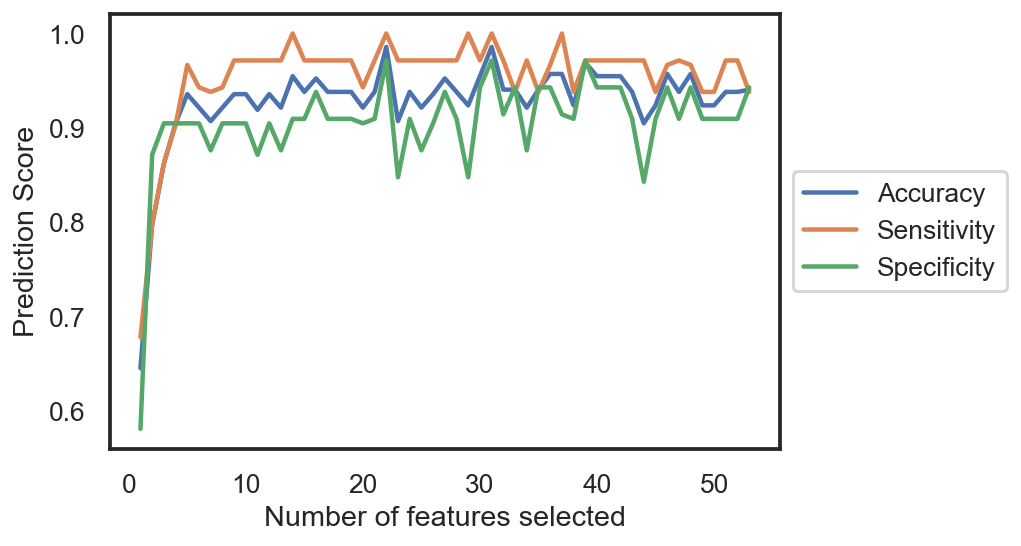

In [287]:
# Create the RFE object and compute a cross-validated score.
#RF= RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, class_weight="balanced",  random_state=42)
RF=RandomForestClassifier(n_estimators=100, random_state=42)


# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# The "accuracy" scoring is proportional to the number of correct
# classifications
accuracy = RFECV(estimator=RF, cv=rsk, scoring='accuracy') #'accuracy'
precision = RFECV(estimator=RF, cv=rsk, scoring='precision') #'accuracy'
recall = RFECV(estimator=RF, cv=rsk, scoring='recall') #'accuracy'

accuracy.fit(X, y)
precision.fit(X, y)
recall.fit(X,y)

print("Optimal number of features : %d" % accuracy.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Prediction Score")
plt.plot(range(1, len(accuracy.grid_scores_) + 1), 
         accuracy.grid_scores_, label='Accuracy')
plt.plot(range(1, len(precision.grid_scores_) + 1), 
         precision.grid_scores_, label='Sensitivity')
plt.plot(range(1, len(recall.grid_scores_) + 1), 
         recall.grid_scores_, label='Specificity')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [288]:
print ("The highest accuracy features is {}%" .format(max(accuracy.grid_scores_)*100))

The highest accuracy features is 98.57142857142858%


Rank features by the features importance from `RF-RFECV` algorithms. 

In [289]:
list_of_tuples = list(zip(MLfeatures.columns, 
                          accuracy.estimator_.feature_importances_, 
                          accuracy.support_, accuracy.ranking_))
df_feat = pd.DataFrame(list_of_tuples, columns = ['Metabolites', 'Importance', 
                                                  'Selected', 'Ranking'])
df_feat = df_feat.sort_values(by='Importance', ascending=False)
#df_feat = df_feat.loc[df_feat['Ranking'] == True]
df_feat.head(20)

Metabolites  Importance  Selected  Ranking
0          2102    0.139006      True        1
15         5077    0.114749      True        1
11         5868    0.087808     False       10
8          4025    0.073606     False       11
13         5698    0.062962      True        1
1          1481    0.057985      True        1
12         4278    0.055068     False       17
9          3963    0.040342     False       25
21         6594    0.037111     False       22
10         6578    0.035613      True        1
4          2240    0.034511      True        1
17         6956    0.031247      True        1
20         3564    0.030249      True        1
3          5381    0.029645      True        1
5          2803    0.028481      True        1
2          5010    0.025076      True        1
19         5310    0.023746      True        1
16         6637    0.022378     False        5
6          2731    0.021606      True        1
18         5737    0.018608     False       20

_Select the features with the top 20 RF feature importance score or all features selected by the RFECV-RF_

In order to use the top features with the lowest q-values, use the the `stat_sig` dataframes

In [290]:
RFfeatures = NMRMS[df_feat['Metabolites'][:10].tolist()] # top 20 ML features
#MLfeatures = NMRMS[df_feat['Metabolites'].tolist()] # all selected features from RFECV-RF
#MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

#### Converge the PLS-DA and RF features.

In [291]:
PLSfeatures.columns

Index([2102, 5310, 6594, 2359, 1481, 2240, 2803, 5381, 5698, 6578], dtype='object')

In [292]:
RFfeatures.columns

Index([2102, 5077, 5868, 4025, 5698, 1481, 4278, 3963, 6594, 6578], dtype='object')

In [293]:
final_features = set(PLSfeatures) - (set(PLSfeatures) - set(RFfeatures))

In [294]:
final_features

{1481, 2102, 5698, 6578, 6594}

In [295]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [296]:
MS_labels[MS_labels.ID.isin(final_features)]

ID      Mode  RT [min]                               Name  \
1480  1481  positive     6.290                               1481   
2101  2102  positive     3.449  N,N-Diisopropylethylamine (DIPEA)   
5697  5698  negative     3.381                               5698   
6577  6578  negative     0.832                               6578   
6593  6594  negative     3.871           N-Acetyl-D-glucosaminate   

                 Formula  
1480                 NaN  
2101            C8 H19 N  
5697  C24 H43 N O12 P2 S  
6577           C6 H N O5  
6593         C8 H15 N O7

In [297]:
MLfeatures = NMRMS[list(final_features)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

### c. Machine Learning for RCC Prediction

In [298]:
from sklearn.metrics import confusion_matrix

_Machine Learning Model Function_

In [299]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [300]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)



Define features and labels.

In [301]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures.values
y = dfgroup.values

### Grid Search: Random Forest

[Method Reference: towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>
[GridSearchCV sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [302]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = rsk, scoring = 'accuracy', n_jobs = -1, verbose = 2)

In [303]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2584 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 3273 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  2.9min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [304]:
grid_search.best_score_

0.8709677419354839

In [305]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0         0.060184      0.000745         0.006922        0.001420   
1         0.131455      0.004370         0.013265        0.001233   
2         0.191635      0.010389         0.017142        0.002282   
3         0.266274      0.014678         0.023375        0.002057   
4         0.063677      0.002922         0.007964        0.002246   
5         0.142820      0.015898         0.012426        0.004254   
6         0.186779      0.005970         0.017574        0.000944   
7         0.279295      0.019365         0.034222        0.015329   
8         0.067635      0.003406         0.006290        0.000639   
9         0.202942      0.047440         0.016408        0.006557   
10        0.188083      0.008259         0.019816        0.002855   
11        0.258215      0.003835         0.023151        0.000360   
12        0.064736      0.002847         0.006716        0.000750   
13        0.129770      0.003011         0.012481        0.001378   
14        0.193803      0.008104         0.017243        0.000868   
15        0.259286      0.008197         0.024888        0.002250   
16        0.065886      0.003355         0.006379        0.000362   
17        0.129581      0.005172         0.011897        0.000556   
18        0.237037      0.043083         0.034775        0.022889   
19        0.261100      0.011799         0.025233        0.002151   
20        0.064668      0.004065         0.006249        0.000170   
21        0.129149      0.002942         0.011924        0.000467   
22        0.199328      0.011517         0.018220        0.002240   
23        0.266613      0.008497         0.022828        0.000821   
24        0.068522      0.006417         0.007217        0.001782   
25        0.134279      0.008755         0.011895        0.000527   
26        0.194382      0.008266         0.018123        0.001904   
27        0.261234      0.010892         0.030763        0.007582   
28        0.065552      0.002988         0.006103        0.000166   
29        0.129931      0.004196         0.012230        0.001862   
..             ...           ...              ...             ...   
690       0.215704      0.006917         0.018410        0.002127   
691       0.383559      0.037858         0.030808        0.006062   
692       0.084942      0.027433         0.009653        0.004645   
693       0.137307      0.003253         0.012318        0.001576   
694       0.202293      0.010197         0.019491        0.002415   
695       0.283315      0.014072         0.036117        0.006257   
696       0.076129      0.011352         0.006141        0.000159   
697       0.135786      0.008565         0.011612        0.000396   
698       0.200067      0.009877         0.016264        0.003302   
699       0.277570      0.010823         0.026148        0.005948   
700       0.072544      0.006080         0.006442        0.000584   
701       0.152571      0.006870         0.013895        0.001434   
702       0.223111      0.010203         0.019907        0.001882   
703       0.305663      0.019709         0.030113        0.005327   
704       0.080938      0.014762         0.009961        0.003328   
705       0.147672      0.008190         0.013223        0.002037   
706       0.199605      0.005732         0.019383        0.001886   
707       0.258319      0.005943         0.022093        0.000583   
708       0.061222      0.003794         0.006881        0.001371   
709       0.130562      0.004723         0.013007        0.001640   
710       0.188914      0.006977         0.016347        0.000258   
711       0.266441      0.017389         0.025826        0.003830   
712       0.061772      0.005687         0.006771        0.000794   
713       0.127702      0.004664         0.012457        0.001312   
714       0.202615      0.002509         0.019370        0.003084   
715       0.280995      0.041862         0.027012        0.004255   
716

### Grid Search: SVM-RBF

In [306]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [307]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 out of 100 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


{'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}

In [308]:
grid_search.best_score_

0.9032258064516129

In [309]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.000804      0.000183         0.000481        0.000030     0.1   
1        0.000666      0.000114         0.000375        0.000103     0.1   
2        0.000499      0.000096         0.000308        0.000070     0.1   
3        0.000832      0.000231         0.000456        0.000037     0.1   
4        0.000782      0.000328         0.000411        0.000031     0.1   
5        0.000668      0.000129         0.000420        0.000054       1   
6        0.001041      0.000472         0.001829        0.001860       1   
7        0.001020      0.000508         0.000470        0.000059       1   
8        0.000991      0.000311         0.000572        0.000181       1   
9        0.000683      0.000031         0.000602        0.000323       1   
10       0.001092      0.000973         0.000431        0.000036      10   
11       0.000876      0.000289         0.000445        0.000072      10   
12       0.001409      0.001731         0.000741        0.000852      10   
13       0.000674      0.000262         0.000315        0.000050      10   
14       0.000734      0.000055         0.000492        0.000171      10   
15       0.000816      0.000288         0.000496        0.000148     100   
16       0.001014      0.000638         0.001266        0.000861     100   
17       0.001204      0.000590         0.001109        0.000936     100   
18       0.000855      0.000075         0.000749        0.000283     100   
19       0.000697      0.000139         0.000363        0.000076     100   

   param_gamma param_kernel                                      params  \
0         0.01          rbf  {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}   
1         0.03          rbf  {'C': 0.1, 'gamma': 0.03, 'kernel': 'rbf'}   
2          0.1          rbf   {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}   
3          0.3          rbf   {'C': 0.1, 'gamma': 0.3, 'kernel': 'rbf'}   
4            1          rbf   {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}   
5         0.01          rbf    {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}   
6         0.03          rbf    {'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}   
7          0.1          rbf     {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}   
8          0.3          rbf     {'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}   
9            1          rbf     {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}   
10        0.01          rbf   {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}   
11        0.03          rbf   {'C': 10, 'gamma': 0.03, 'kernel': 'rbf'}   
12         0.1          rbf    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}   
13         0.3          rbf    {'C': 10, 'gamma': 0.3, 'kernel': 'rbf'}   
14           1          rbf    {'C': 10, 'gamma': 1.0, 'kernel': 'rbf'}   
15        0.01          rbf  {'C': 100, 'gamma': 0.01, 'kernel': 'rbf'}   
16        0.03          rbf  {'C': 100, 'gamma': 0.03, 'kernel': 'rbf'}   
17         0.1          rbf   {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}   
18         0.3          rbf   {'C': 100, 'gamma': 0.3, 'kernel': 'rbf'}   
19           1          rbf   {'C': 100, 'gamma': 1.0, 'kernel': 'rbf'}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.714286           0.833333           0.583333   
1            0.571429           0.833333           0.666667   
2            0.642857           0.833333           0.666667   
3            0.571429           0.833333           0.750000   
4            0.500000           1.000000           0.666667   
5            0.571429           0.833333           0.666667   
6            0.571429           0.833333           0.666667   
7            0.571429           0.833333           0.666667   
8            0.571429           0.833333           0.750000   
9            0.571429           0.916667           0.833333   
10           0.571429           0.833333           0.666667   
11           0.571429           0.833333           0.750000   
12          

### Grid Search: Lin-SVM

In [310]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 5, 10.]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [311]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   7 out of  30 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.1s finished


{'C': 5, 'kernel': 'linear'}

In [312]:
grid_search.best_score_

0.8225806451612904

In [313]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.001336      0.000523         0.000450        0.000064   0.001   
1       0.000626      0.000153         0.000303        0.000062    0.01   
2       0.000429      0.000012         0.000251        0.000007     0.1   
3       0.000488      0.000101         0.000292        0.000077       1   
4       0.000554      0.000065         0.000312        0.000037       5   
5       0.000731      0.000260         0.000318        0.000100      10   

  param_kernel                            params  split0_test_score  \
0       linear  {'C': 0.001, 'kernel': 'linear'}           0.571429   
1       linear   {'C': 0.01, 'kernel': 'linear'}           0.642857   
2       linear    {'C': 0.1, 'kernel': 'linear'}           0.571429   
3       linear      {'C': 1, 'kernel': 'linear'}           0.571429   
4       linear      {'C': 5, 'kernel': 'linear'}           0.642857   
5       linear   {'C': 10.0, 'kernel': 'linear'}           0.571429   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.833333           0.583333           0.750000           0.833333   
1           0.833333           0.583333           0.833333           0.833333   
2           0.833333           0.666667           0.916667           1.000000   
3           0.833333           0.750000           0.916667           1.000000   
4           0.833333           0.833333           0.916667           0.916667   
5           0.833333           0.833333           0.916667           0.916667   

   mean_test_score  std_test_score  rank_test_score  
0         0.709677        0.116786                6  
1         0.741935        0.109251                5  
2         0.790323        0.160424                4  
3         0.806452        0.151099                2  
4         0.822581        0.103755                1  
5         0.806452        0.132116                2

### Grid Search: kNN

In [314]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(3,30)), 'p': [1,2]}

knn_cls = KNeighborsClassifier()
              
grid_search = GridSearchCV(knn_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [315]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    0.4s finished


{'n_neighbors': 7, 'p': 2}

In [316]:
grid_search.best_score_

0.8548387096774194

In [317]:
pd.DataFrame(grid_search.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.000993  2.783244e-04         0.003381        0.002001   
1        0.000765  2.320012e-04         0.002011        0.000446   
2        0.000611  9.611358e-05         0.002904        0.001828   
3        0.001738  1.923406e-03         0.004621        0.003669   
4        0.000780  3.508757e-04         0.003023        0.002222   
5        0.000615  4.691811e-05         0.002655        0.001946   
6        0.000706  1.895584e-04         0.003414        0.002795   
7        0.000897  6.601151e-04         0.006563        0.006059   
8        0.000785  2.071595e-04         0.008333        0.009260   
9        0.000762  4.139693e-04         0.002531        0.001835   
10       0.001903  2.779143e-03         0.001510        0.000062   
11       0.000928  4.871497e-04         0.006614        0.004609   
12       0.001042  7.004024e-04         0.002979        0.001806   
13       0.000575  4.302445e-05         0.004995        0.005689   
14       0.003245  4.586813e-03         0.001679        0.000109   
15       0.002297  3.514720e-03         0.004113        0.003974   
16       0.000704  1.189461e-04         0.006039        0.005625   
17       0.000698  2.765907e-04         0.002914        0.002352   
18       0.001986  2.755453e-03         0.004091        0.003947   
19       0.001705  2.322023e-03         0.002073        0.000780   
20       0.001163  1.185092e-03         0.003991        0.004552   
21       0.003033  3.276152e-03         0.003109        0.002950   
22       0.000657  1.253954e-04         0.002517        0.001630   
23       0.001180  6.954629e-04         0.005006        0.003866   
24       0.000626  1.557178e-05         0.001837        0.000089   
25       0.000626  5.097222e-05         0.002077        0.000740   
26       0.002407  3.637940e-03         0.001836        0.000187   
27       0.000917  5.866808e-04         0.002106        0.000523   
28       0.000641  9.814741e-06         0.002223        0.000422   
29       0.000658  2.757323e-05         0.003030        0.002110   
30       0.000700  9.078459e-05         0.002278        0.000805   
31       0.000650  1.244235e-04         0.001877        0.000314   
32       0.000552  5.764407e-06         0.001769        0.000139   
33       0.000656  1.780536e-04         0.001795        0.000181   
34       0.000577  1.603166e-05         0.002022        0.000159   
35       0.002201  2.314979e-03         0.002709        0.001553   
36       0.000665  1.170834e-04         0.002568        0.001757   
37       0.000834  3.083201e-04         0.001869        0.000052   
38       0.000572  2.268412e-05         0.001830        0.000179   
39       0.000507  9.787129e-05         0.001639        0.000451   
40       0.001008  5.869080e-04         0.001974        0.000182   
41       0.000468  7.817154e-05         0.001209        0.000199   
42       0.000346  1.718375e-05         0.001030        0.000058   
43       0.000342  4.761395e-05         0.001367        0.000742   
44       0.000303  3.904082e-05         0.001001        0.000082   
45       0.000250  3.547233e-06         0.000918        0.000038   
46       0.000250  3.552357e-06         0.000894        0.000021   
47       0.000251  7.375732e-06         0.000907        0.000014   
48       0.000270  4.021086e-05         0.000902        0.000035   
49       0.000249  8.609519e-07         0.000945        0.000064   
50       0.000289  4.661678e-05         0.000967        0.000099   
51       0.000312  6.165130e-05         0.001051        0.000170   
52       0.000254  3.976948e-06         0.000901        0.000028   
53       0.000249  9.608003e-07         0.000911        0.000026   

   param_n_neighbors param_p                       params  split0_test_score  \
0                  3       1   {'n_neighbors': 3, 'p': 1}           0.642857   
1                  3       2   {'n_neighbors': 3, 'p': 2}           0.714286   
2                  4   

### Train Machine Learning Models.

In [318]:
# Random Forest

#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=150, min_samples_split=2, 
                          min_samples_leaf=1, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# Linear-SVM
linsvm = svm.SVC(C = 5, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 10, gamma = 0.3, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
knn = KNeighborsClassifier(n_neighbors=7, p=2)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


**AUC**

In [319]:
sns.set_context('talk', font_scale=0.8)

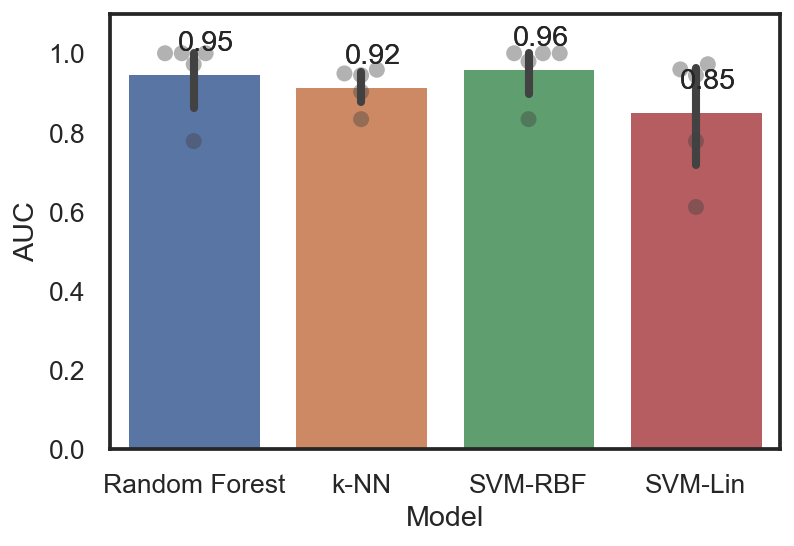

In [320]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');
#plt.savefig('AUC_upRCC.svg', dpi=300)

**Accuracy**

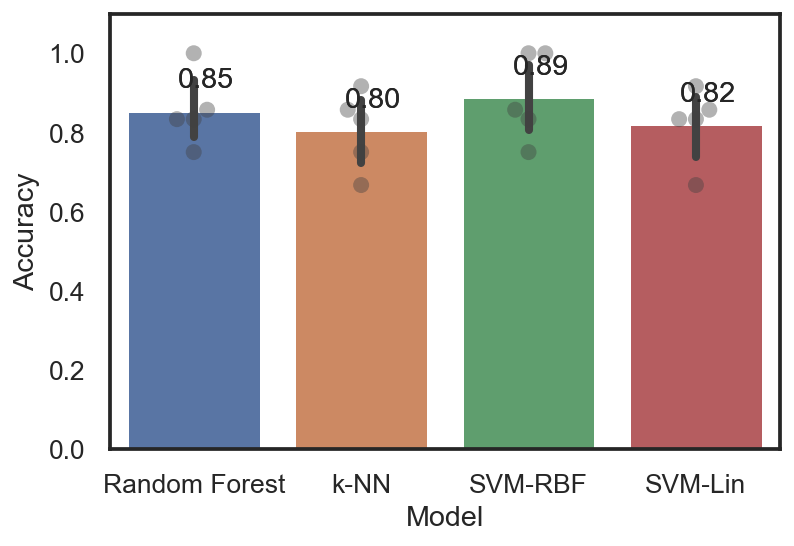

In [321]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

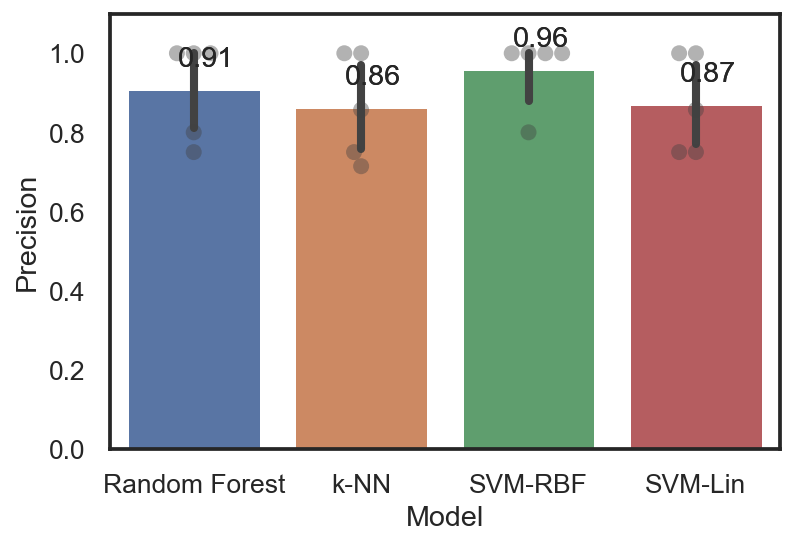

In [322]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

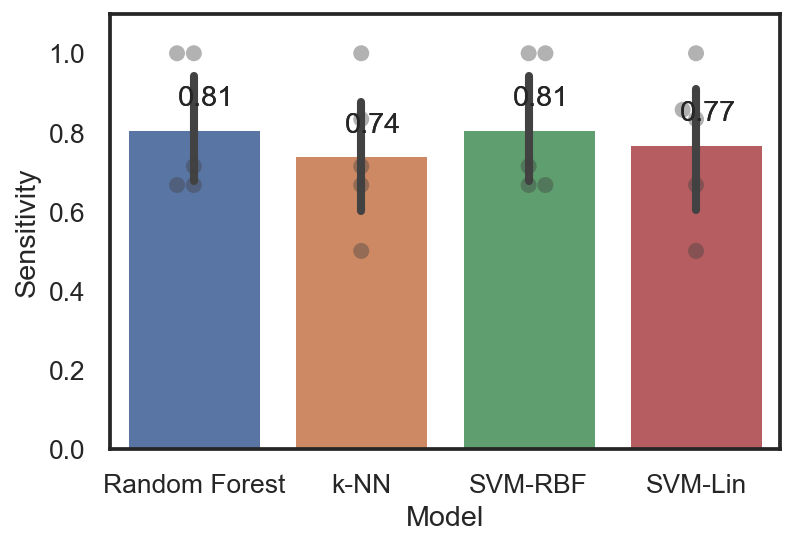

In [323]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

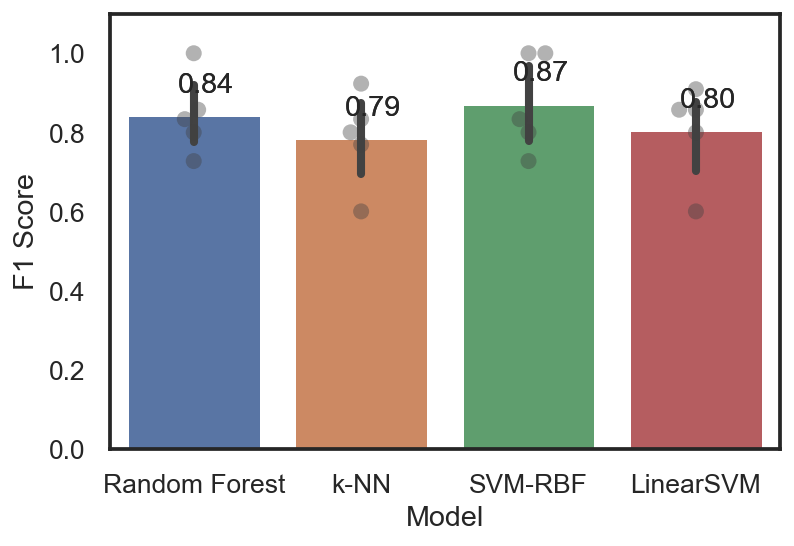

In [324]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

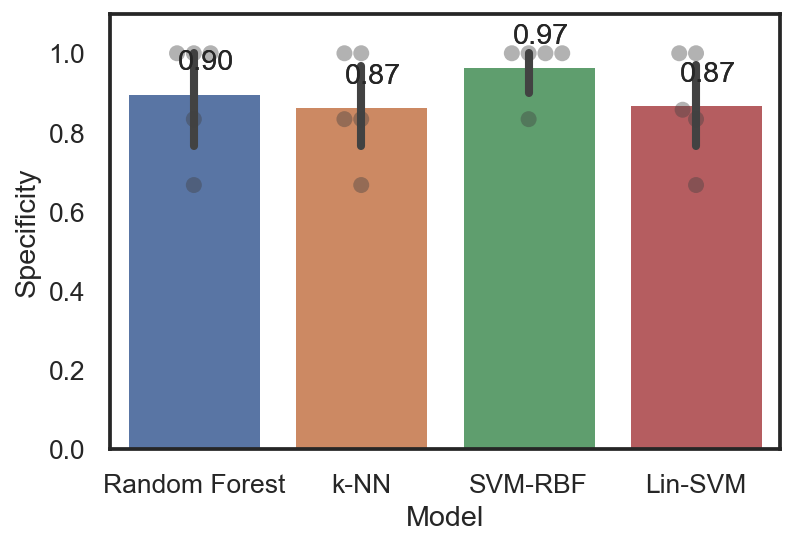

In [325]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'Lin-SVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

### Chemical Information of the Biomarkers

In [326]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx')

In [327]:
MS_labels[MS_labels.ID.isin(MLfeatures.columns)]

ID      Mode  RT [min]                               Name  \
1480  1481  positive     6.290                               1481   
2101  2102  positive     3.449  N,N-Diisopropylethylamine (DIPEA)   
5697  5698  negative     3.381                               5698   
6577  6578  negative     0.832                               6578   
6593  6594  negative     3.871           N-Acetyl-D-glucosaminate   

                 Formula  
1480                 NaN  
2101            C8 H19 N  
5697  C24 H43 N O12 P2 S  
6577           C6 H N O5  
6593         C8 H15 N O7

An alternative way to plot the feature importance/

feature_imp = pd.DataFrame({'Features': MLfeatures.columns, 
                           'Importance': RF.feature_importances_})
feature_imp.sort_values(by='Importance', ascending=True, inplace=True);
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp['Features'], 
            y=feature_imp['Importance']);

In [328]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


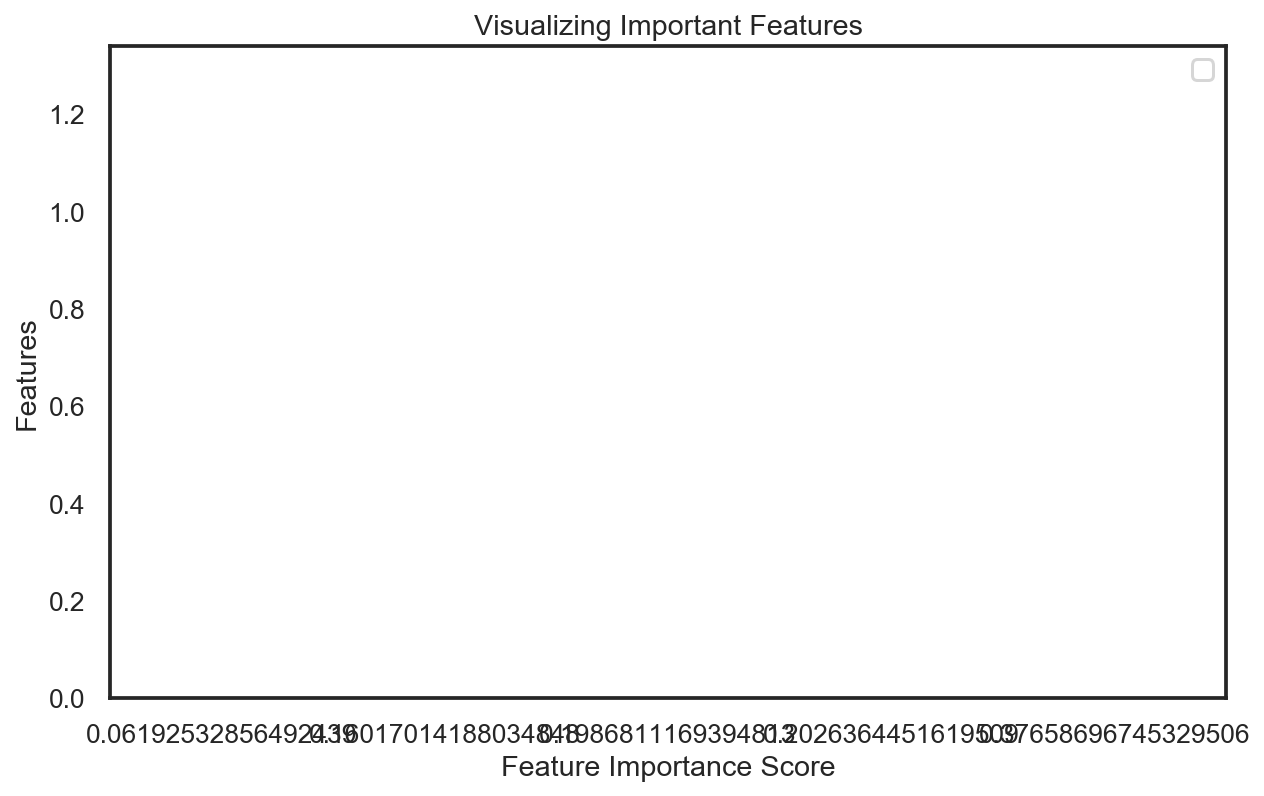

In [329]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### d. Potential Biomarkers: PCA, HCA, Boxplot Visualization

In [330]:
#biomarker_feat = dummydf[df_feat['Metabolites']]
#biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0)
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

_Rename column in biomarker dataframe to reduce length of feature name_

In [331]:
biomarker.rename(columns={'4-(2-Aminoethyl)benzenesulfonylfluoride':'AEBSF',
                          'N,N-Diisopropylethylamine (DIPEA)':'DIPEA',
                          '2-Aminoacetophenone;O-Acetylaniline':'O-Acetylaniline'}, 
                 inplace=True)

**p and q values associated with the metabolite panel in the model cohort**

In [332]:
stat_sig[stat_sig.Metabolite.isin(biomarker.columns)]

Metabolite  T-test p-value  FDR p-value  Reject H0
815        2102    7.480753e-08     0.000157       True
593        1481    4.260921e-05     0.001362       True
1993       6578    8.784423e-04     0.009105       True
1742       5698    1.276625e-03     0.011583       True
1996       6594    3.203173e-03     0.021601       True

#### Boxplot

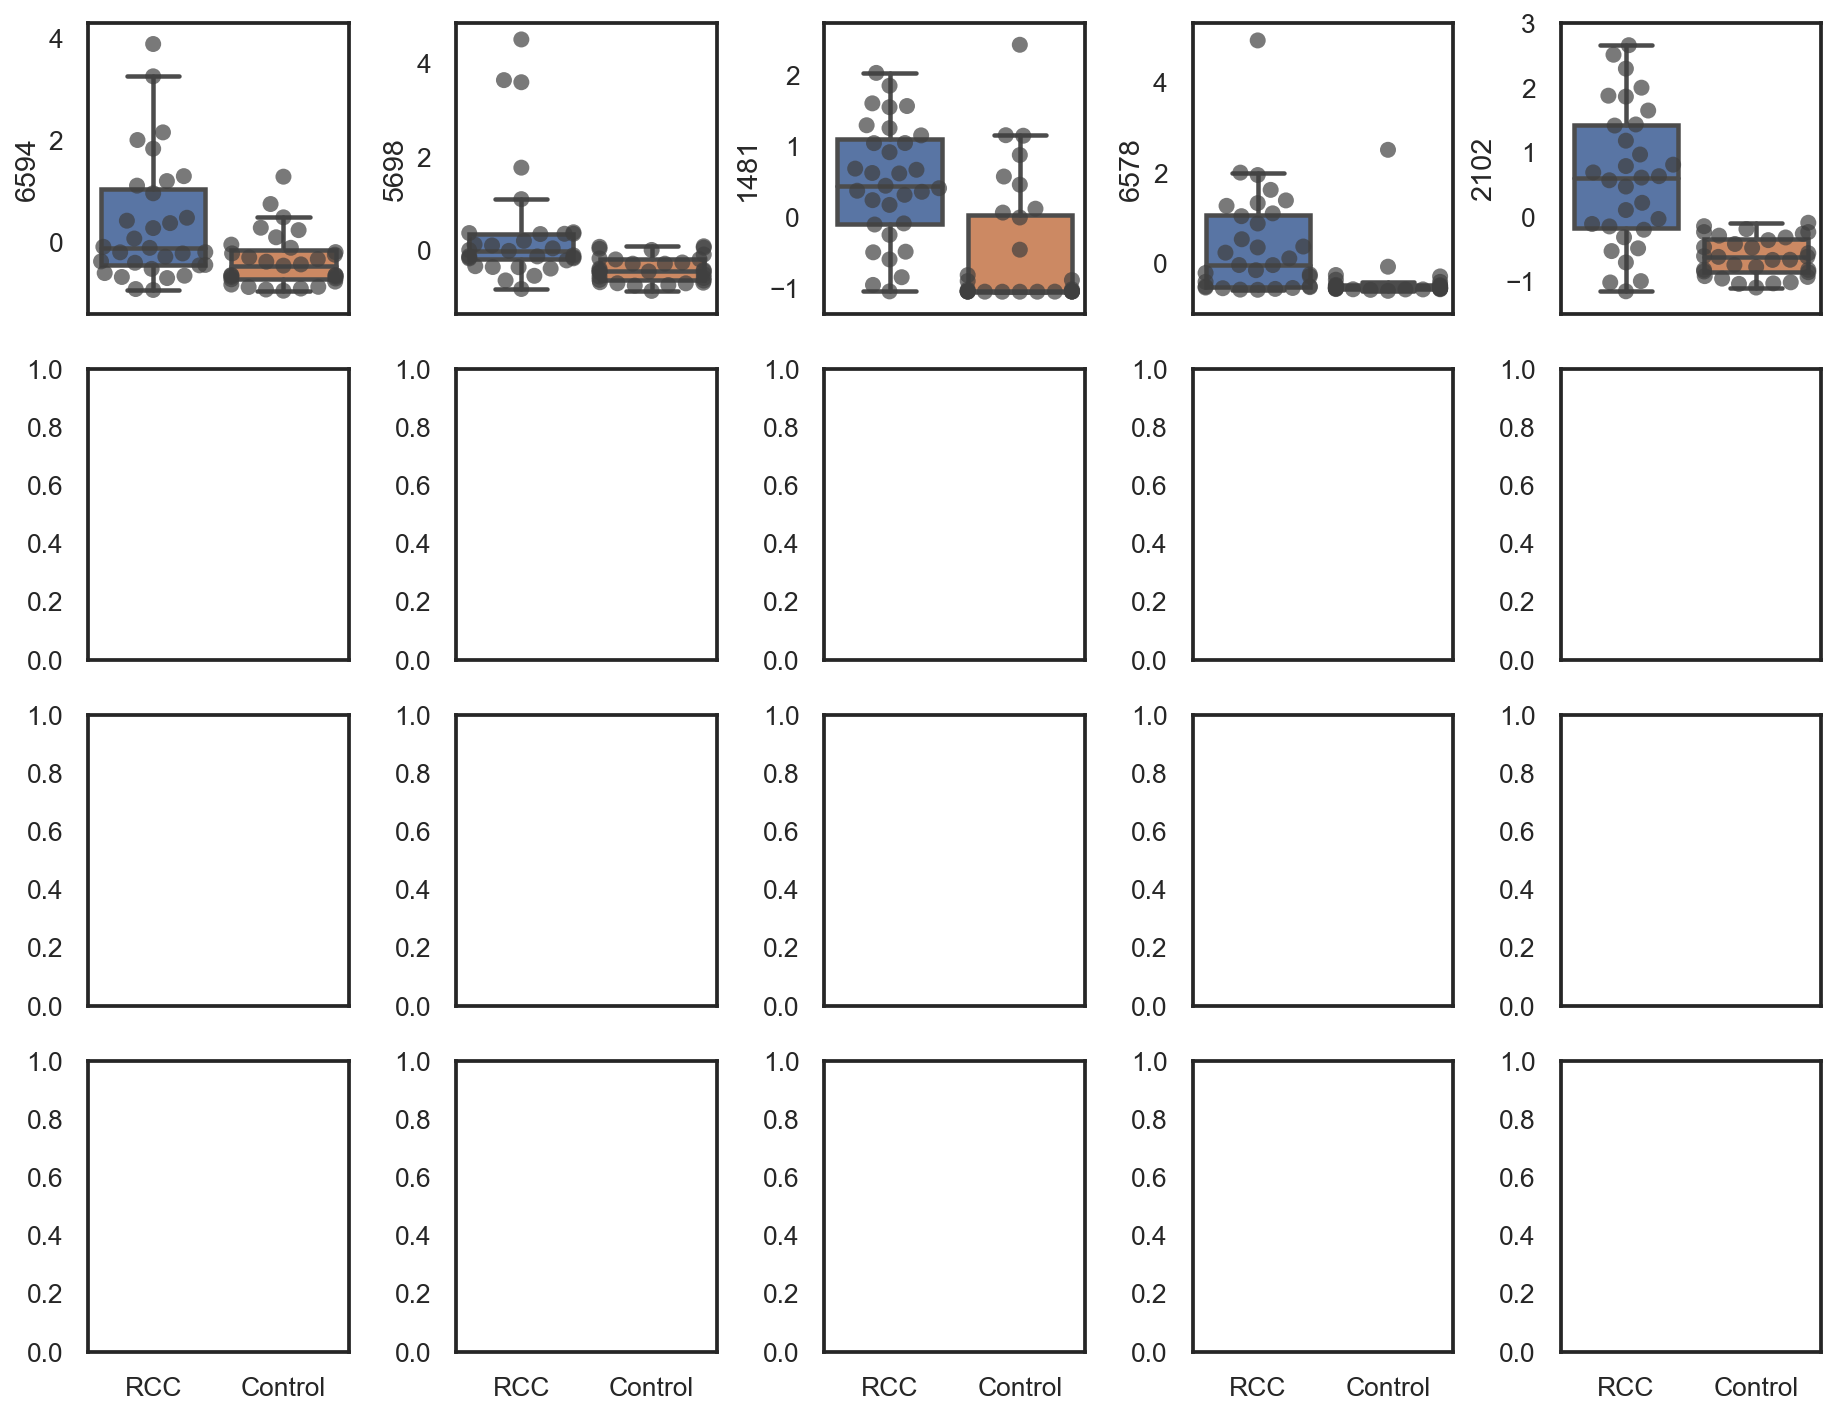

In [333]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(13, 10))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

#### PCA

In [334]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

PCA score plots using all ML features

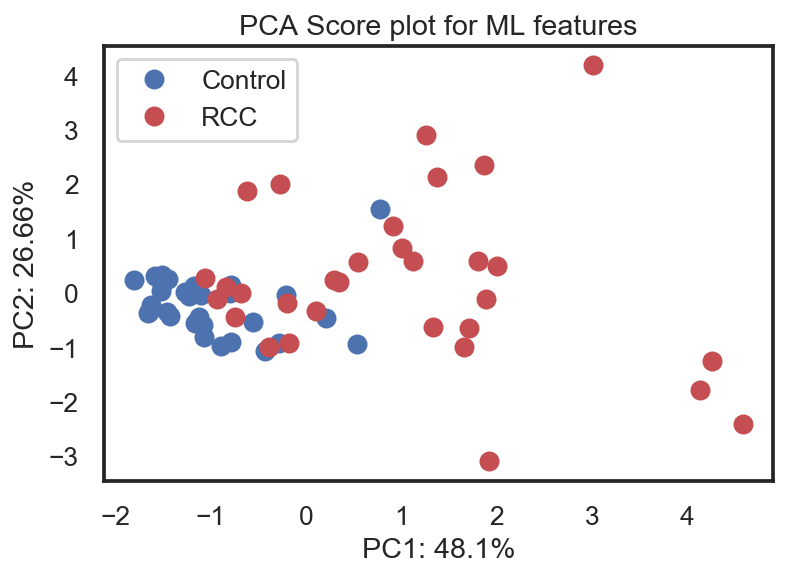

In [335]:
ylabel = biomarker['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [336]:
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

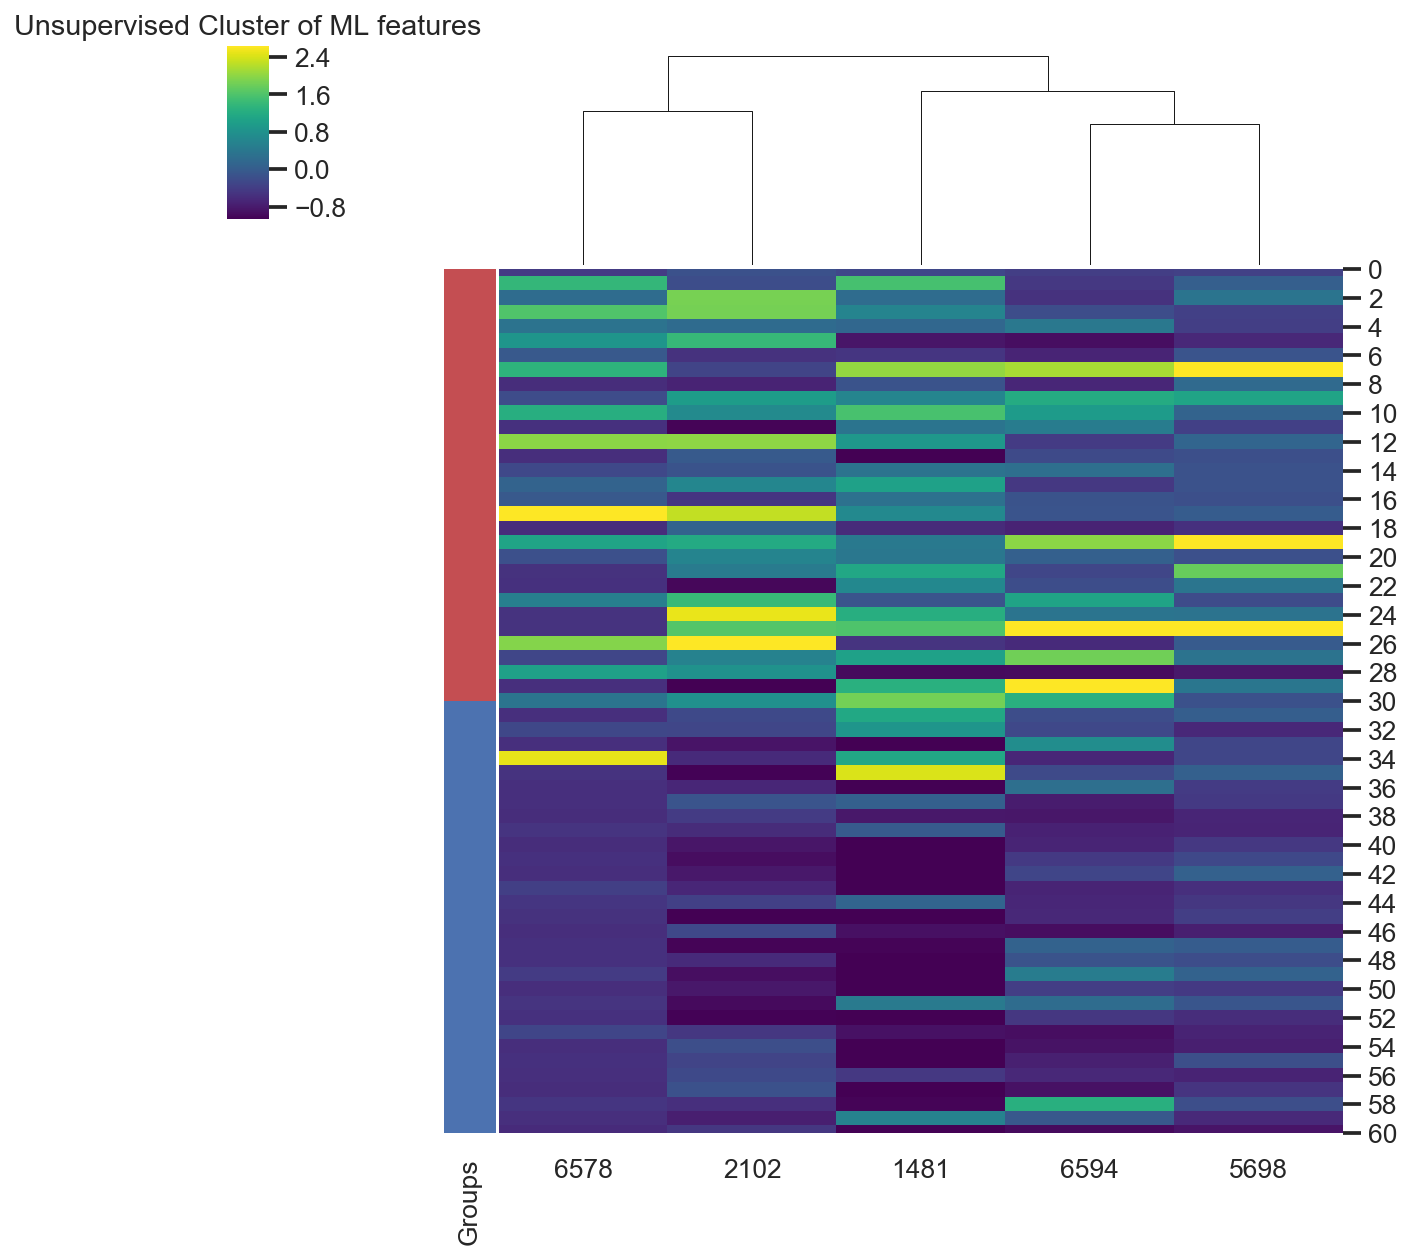

In [337]:
groups_two = biomarker.pop('Groups')
biomarker = biomarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**Hierarchial Clustering using features with _q_ value < 0.05**

In [338]:
# MLfeatures
MLfeatures = NMRMS[upRCC] # > 2fold, q<0.05, [RCC]>[Controls]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

In [339]:
#Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[upRCC] # > 2fold, q<0.05, [RCC]>[Controls]
qfeatures =(qfeatures - qfeatures.mean(axis=0))/qfeatures.std(axis=0) #autoscaling
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)
print ('The total number of features in this DF is:', len(upRCC))

The total number of features in this DF is: 118


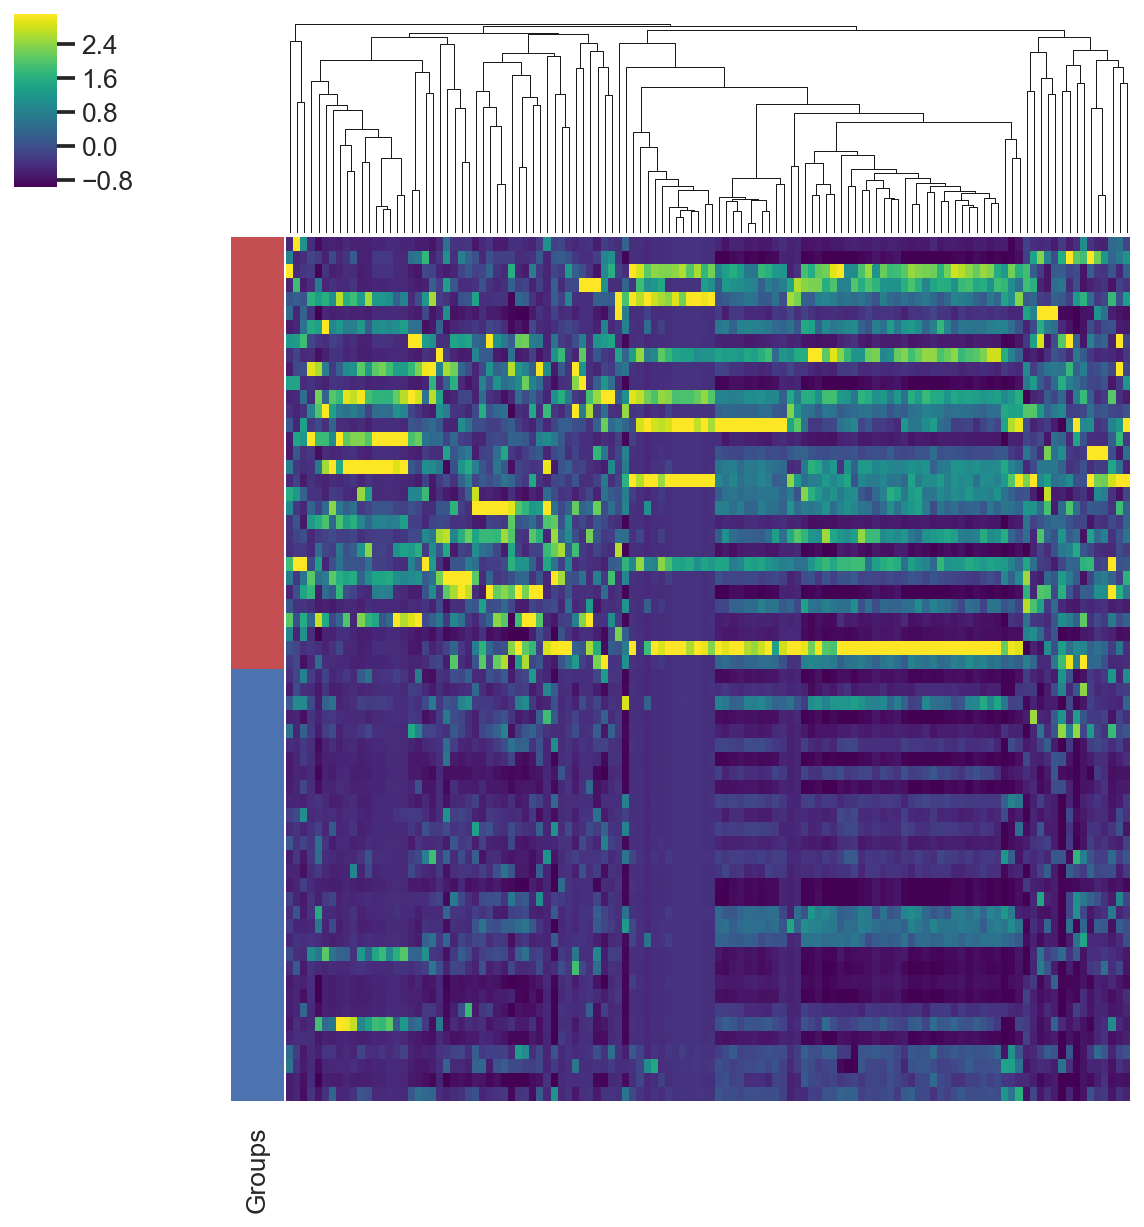

In [340]:
groups_two = qmarker.pop('Groups')
qmarker = qmarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
hca_qmarker = sns.clustermap(qmarker, method="weighted", 
               metric='euclidean', cmap="viridis", 
               row_cluster=False, row_colors=row_colors, 
               robust=True, xticklabels=False, 
               yticklabels=False);
#plt.title('Unsupervised Cluster of ML features');

#save figure
#hca_qmarker.savefig("hca_qmarker.svg")
# define biomarker dataframe again because of the .pop method
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)


### [Go back to notebook content](#0)

# 2. RCC Prediction: Test Cohort
<a id="2"></a>

In [341]:
testcohort = pd.read_excel('data/testcohort.xlsx')

In [342]:
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 5)

Define features and labels.

In [343]:
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 5)
(194,)


### Call the tuned machine learning algorithms

In [344]:
RF

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [345]:
linsvm

SVC(C=5, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [346]:
clf

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.3, kernel='rbf',
    max_iter=-1, probability=True, random_state=42, shrinking=True, tol=0.001,
    verbose=False)

In [347]:
knn

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=7, p=2,
                     weights='uniform')

In [348]:
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Linear-SVM
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# SVM
#clf = svm.SVC(kernel='linear', probability=True)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


**AUC**

In [349]:
sns.set_context('talk', font_scale=0.8)

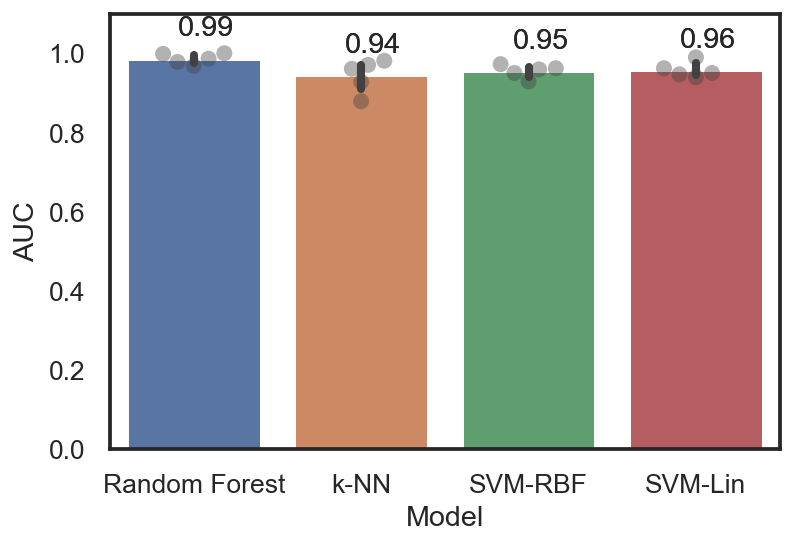

In [350]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

**Accuracy**

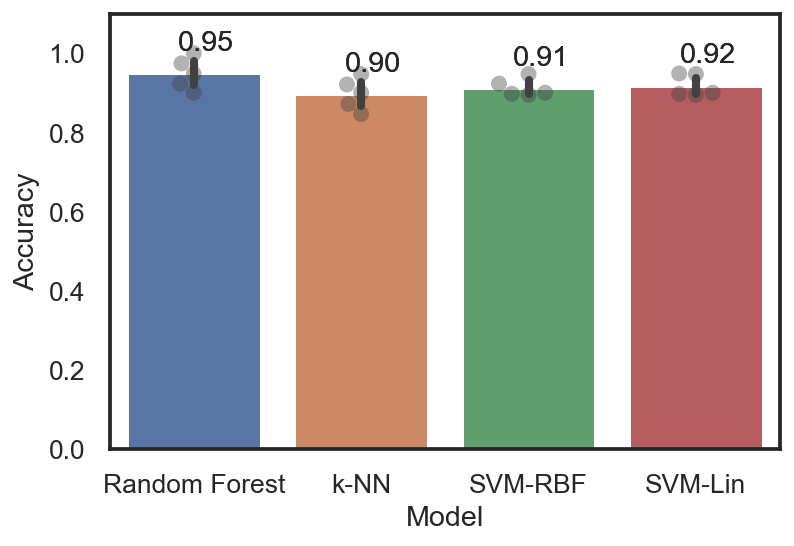

In [351]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

**Precision**

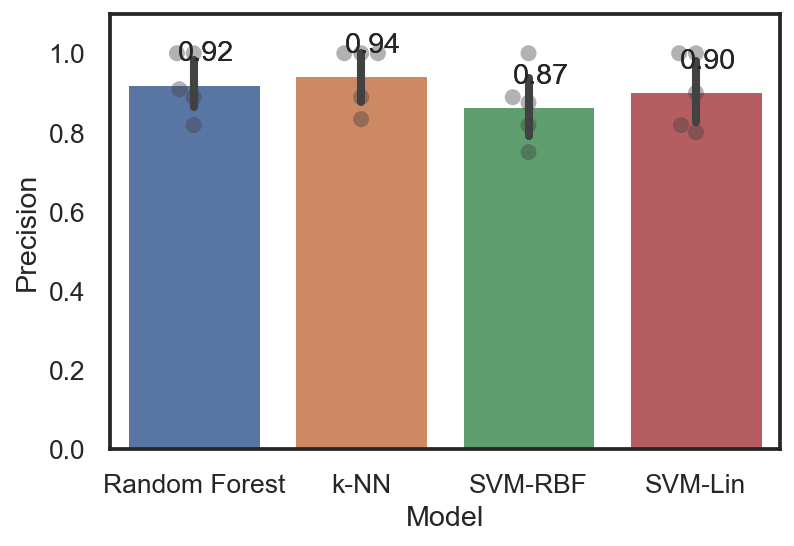

In [352]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

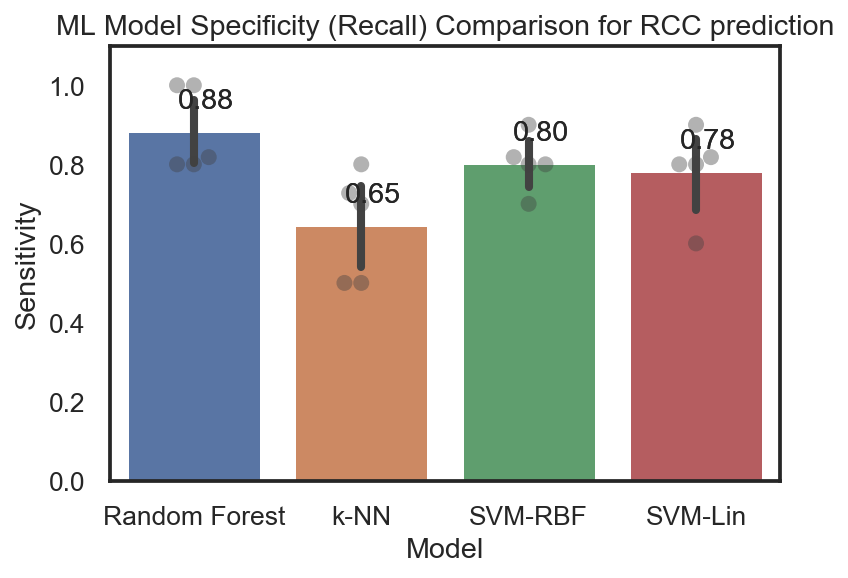

In [353]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

**F1 Score**

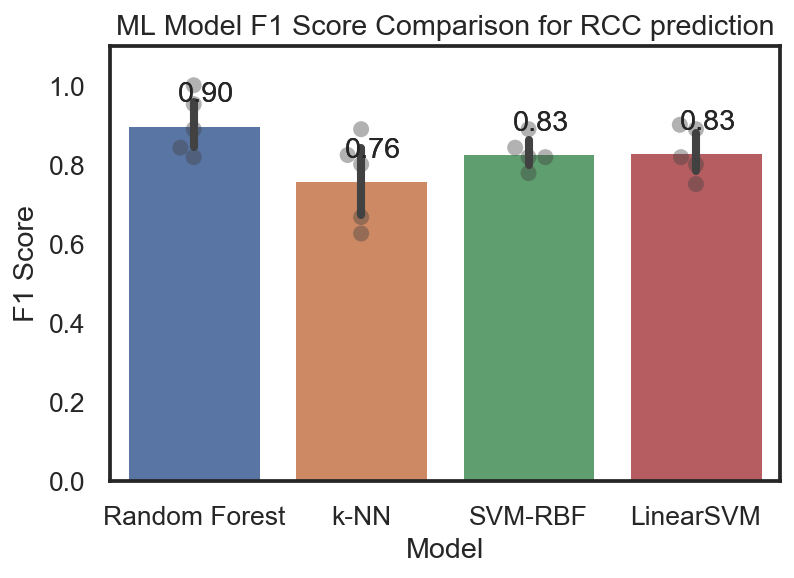

In [354]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

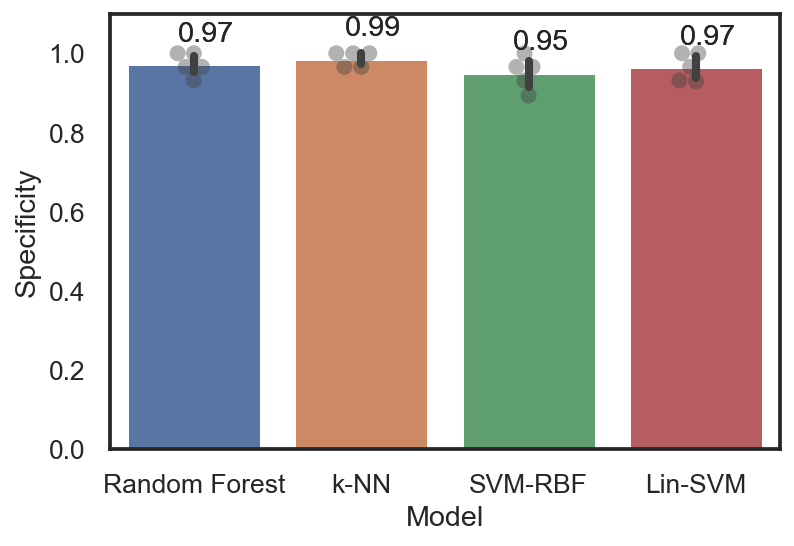

In [355]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'Lin-SVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

The best classifier is RF, and here are the feature importance from random forest:

In [356]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures2.columns.astype(float)).sort_values(ascending=False)

No handles with labels found to put in legend.


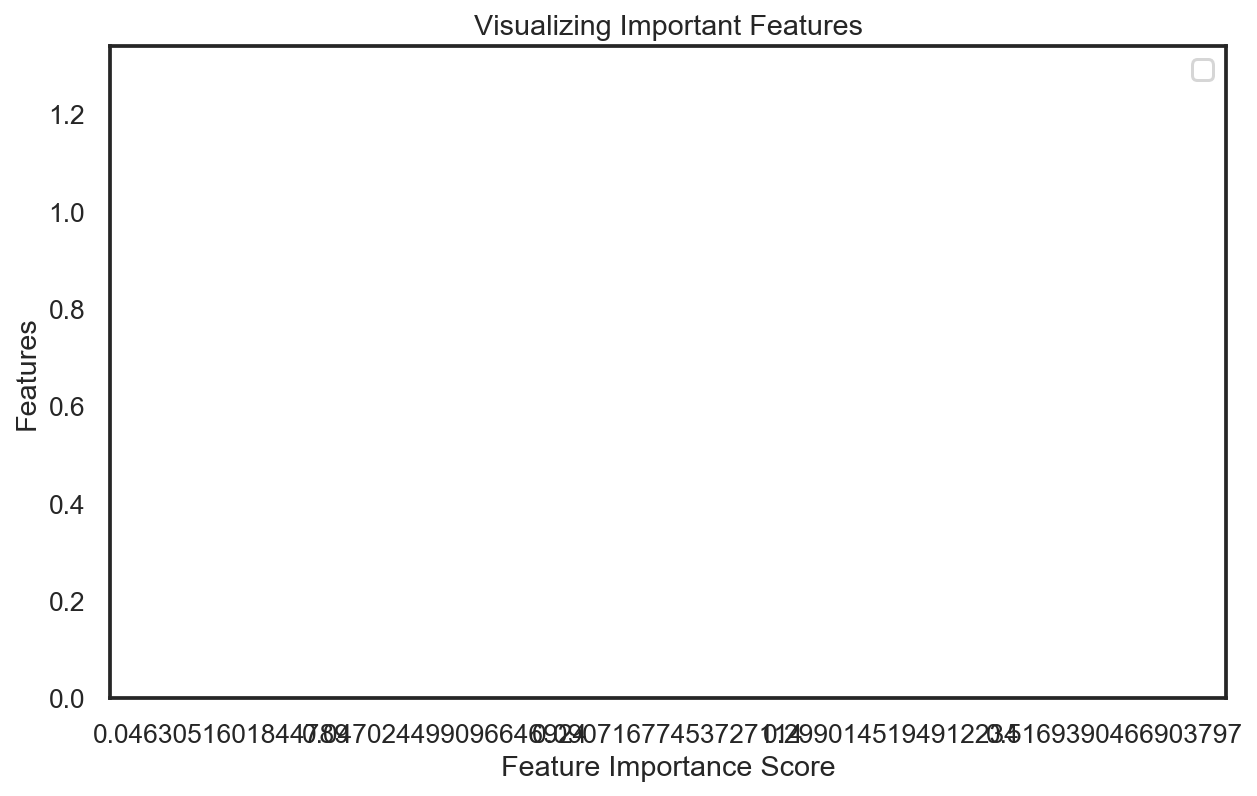

In [357]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [358]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 5)


In [359]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 6)

**_T_-test for metabolic features in the test cohort**

In [360]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [361]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

Metabolite  T-test p-value   FDR p-value  Reject H0
4       2102    6.805514e-11  3.402757e-10       True
2       1481    3.639234e-07  9.098084e-07       True
0       6594    3.604872e-04  6.008120e-04       True
3       6578    1.035021e-03  1.293776e-03       True
1       5698    6.134801e-03  6.134801e-03       True

Boxplot

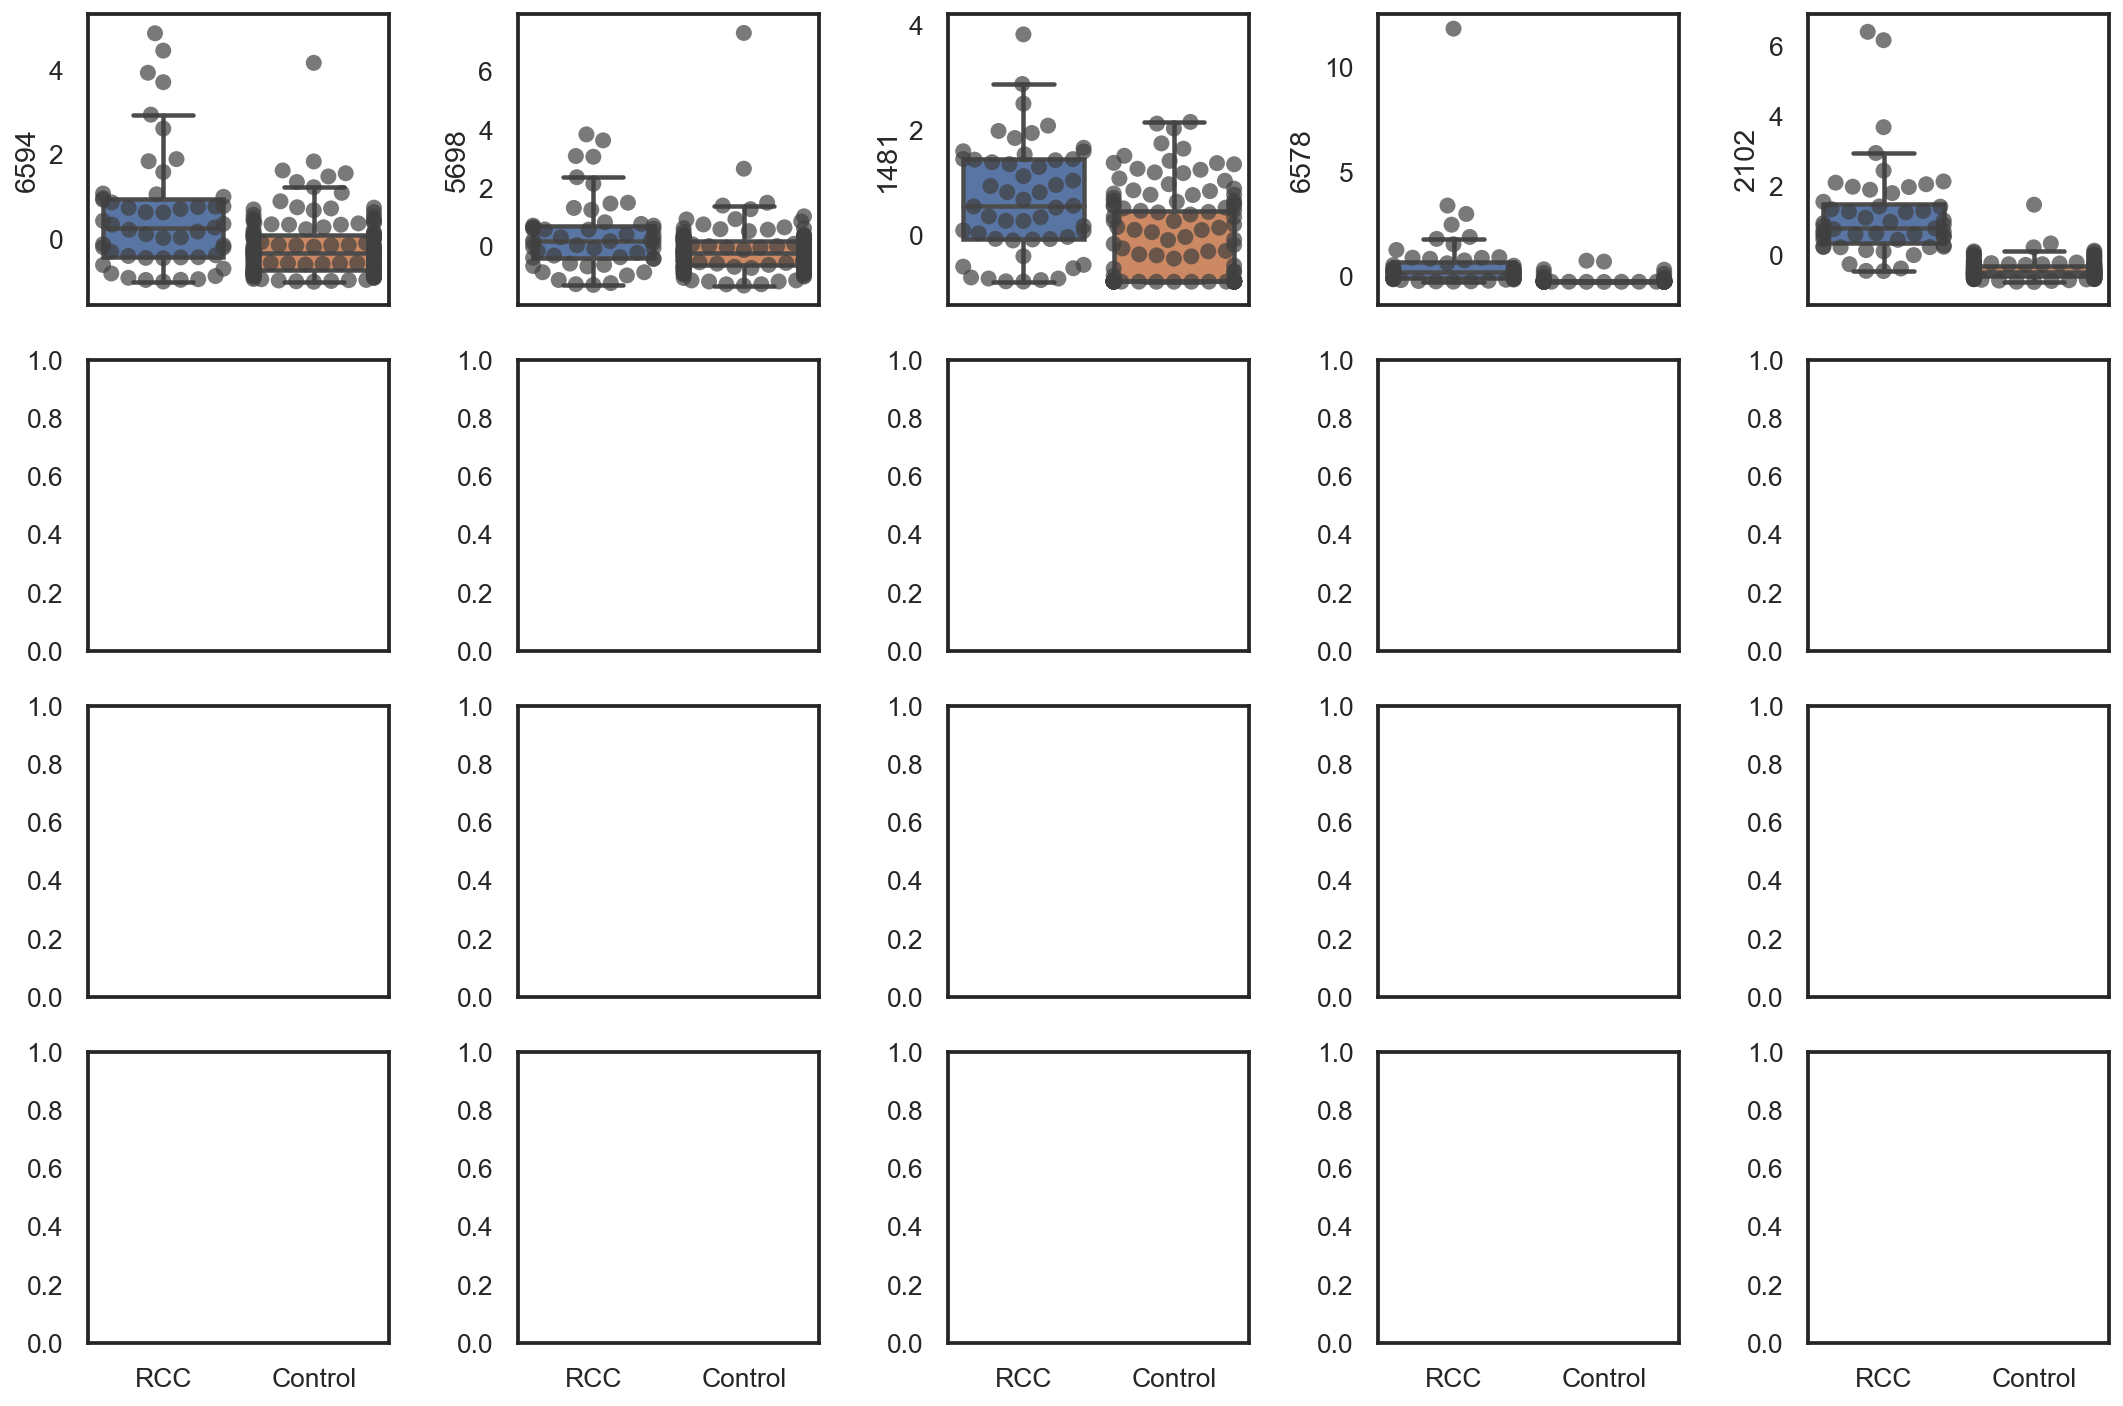

In [362]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=4, ncols=5, sharex=True, figsize=(15, 10))
for idx, feat in enumerate(biomarker2.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker2, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots2.svg', dpi=300)

**PCA score plots using all ML features**

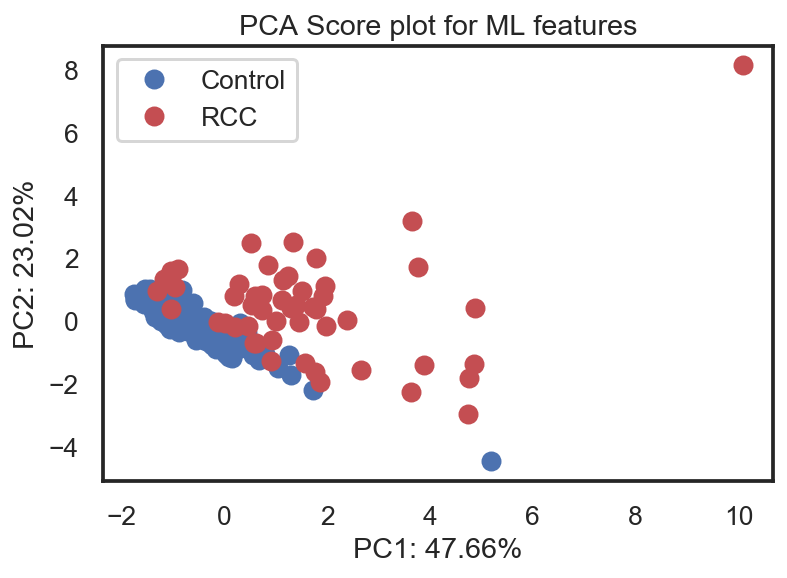

In [363]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
PCA_Python(MLfeatures2, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [364]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 6)

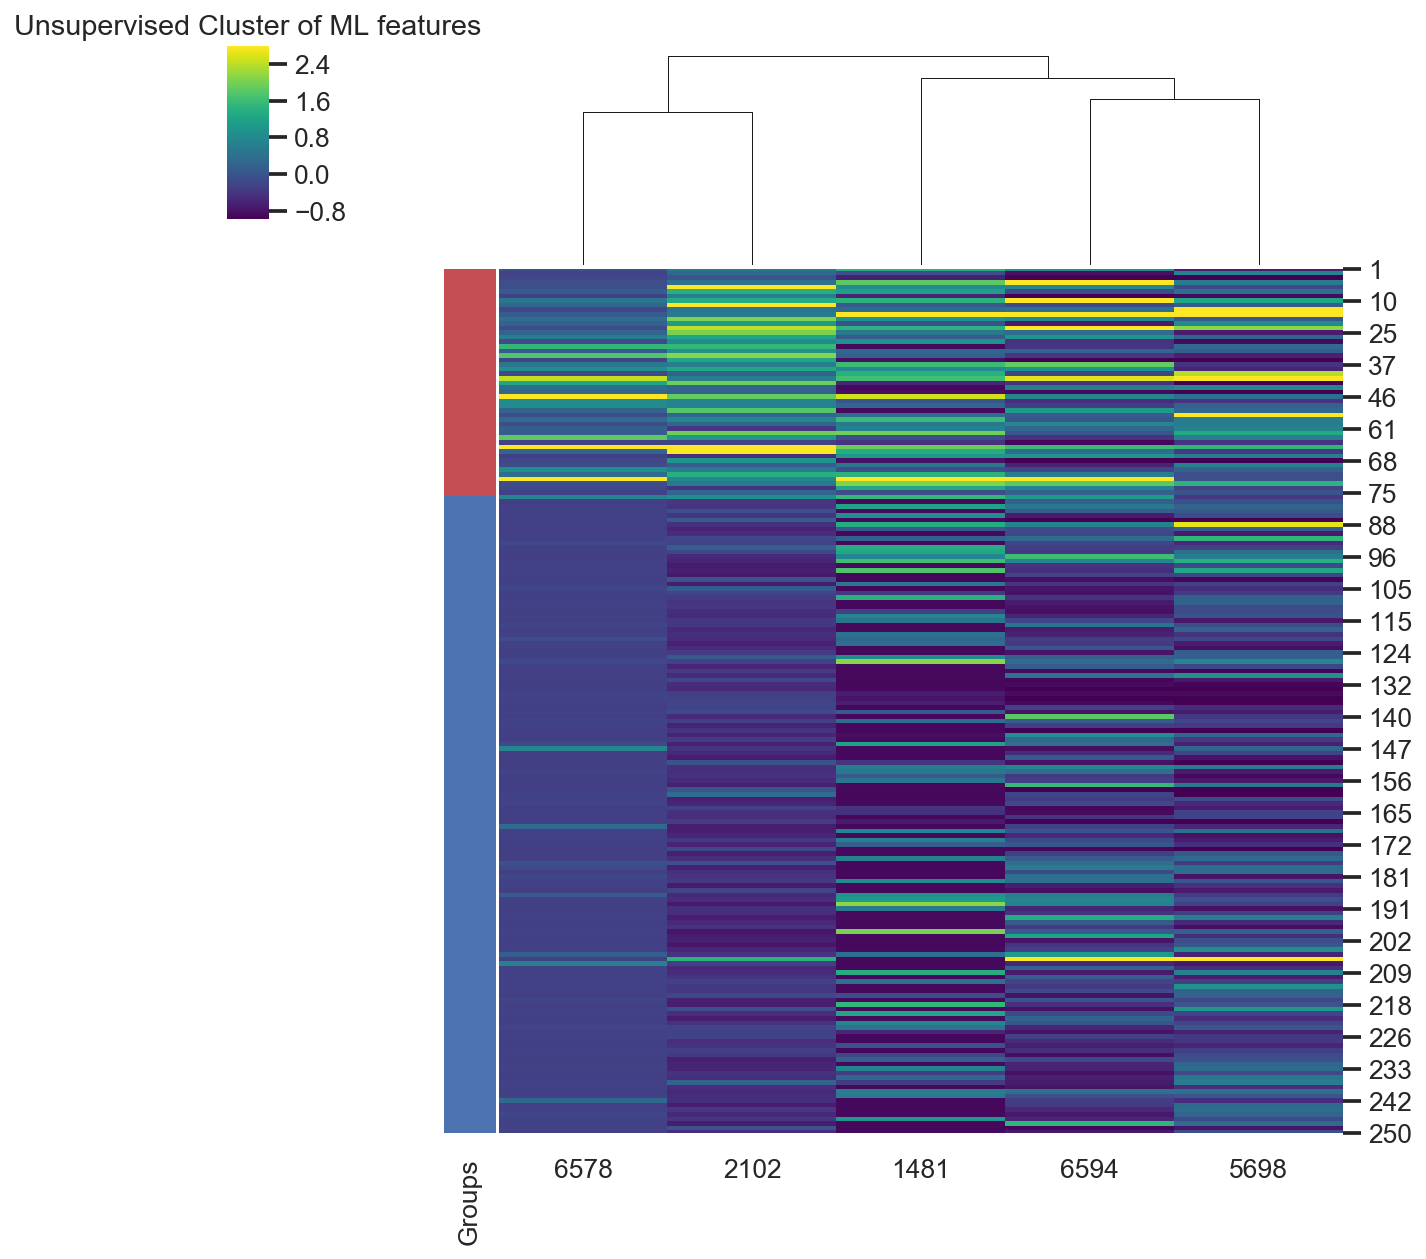

In [365]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)

### [Go back to notebook content](#0)

# 3. Chemical Information of Biomarkers
<a id="3"></a>

In [366]:
MS_labels_bmarkers = MS_labels[MS_labels.ID.isin(MLfeatures.columns)]
print(MS_labels_bmarkers.shape)
MS_labels_bmarkers;

(118, 5)


In [367]:
MS_labels_qmarkers = MS_labels[MS_labels.ID.isin(qfeatures.columns)]
print(MS_labels_qmarkers.shape)
MS_labels_qmarkers.head()

(118, 5)


ID      Mode  RT [min] Name            Formula
311  312  positive     4.523  312   C11 H10 N6 O9 P2
428  429  positive     4.525  429  C10 H12 N8 O13 P2
687  688  positive     4.009  688                NaN
725  726  positive     6.009  726        C8 H19 N O2
799  800  positive     4.125  800     C19 H36 N O6 P

MS_labels_bmarkers.to_excel('RCC_20features.xlsx')

MS_labels_qmarkers.to_excel('RCC_472features.xlsx')